In [1]:
import os

import sys
import logging
import numpy as np
import pandas as pd
import IPython.display as ipd

import librosa
import librosa.display

In [2]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(os.path.dirname(currentdir))
if isnotebook():
    sys.path.append(parentdir)
    sys.path.insert(0, parentdir)
else:
    sys.path.insert(0, currentdir)
    print(currentdir)

In [3]:
logging.root.handlers = []
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [4]:
from dataparsing.parsing_functions import DataParsingStrategy
from dataparsing.output_strategies import DataOutputStrategy, convinAIentOutputStrategy
from dataparsing.parsing_strategy_selector import search_suitable_dataparsing_strategy_for_file
from dataparsing import parsing_functions

from anAIlysis import ESA
from anAIlysis import signal_processing as DSP
# from anAIlysis import plotting as eplt
# from anAIlysis import signal_analysis as SA
from anAIlysis import get_samplerate as GSR
from anAIlysis import file_handler as fh

np.random.seed(seed=42)

In [5]:
# Use WebAgg if no display is connected (e.g. ssh) and not running as notebook
import matplotlib
if (os.name == 'posix' and "DISPLAY" not in os.environ) and not isnotebook():
    matplotlib.use('WebAgg')
elif isnotebook():
    try:
        get_ipython().run_line_magic('matplotlib', 'widget')
    except ModuleNotFoundError:
        get_ipython().run_line_magic('matplotlib', 'inline')

# Return used Matplotlib backend
logger.info(f"Matplotlib backend: {matplotlib.get_backend()}")

import matplotlib.pyplot as plt

INFO:__main__:Matplotlib backend: module://ipympl.backend_nbagg


 ## Example Plot
 $$f(x) = \sin(x)$$

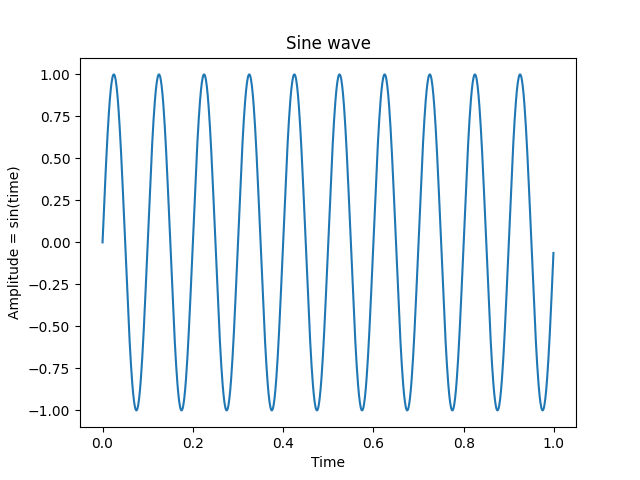

In [6]:
fs = 1e3
length = 1 # in seconds
time = np.arange(0, length, 1 / fs)

theta = 0
frequency = 10
amplitude = 1
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)

plt.figure()
plt.plot(time, sinewave)
plt.title('Sine wave')
plt.xlabel('Time')
plt.ylabel('Amplitude = sin(time)')
plt.show()

 ## Example Analysis
 ### Spectrum
 $$\mathcal{F}\{f(x)\}$$

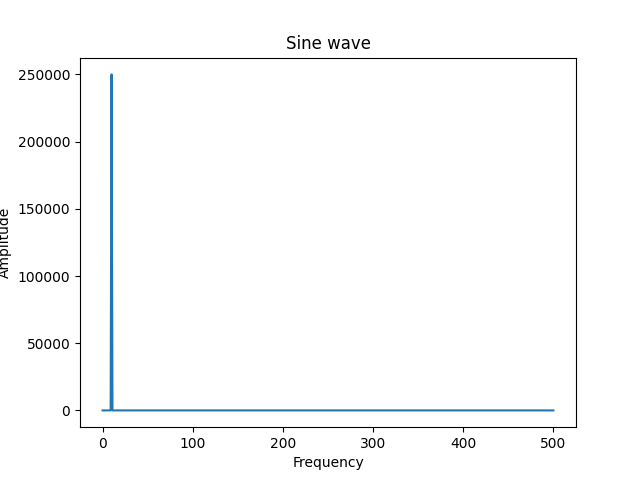

In [7]:
freq, fft = DSP.power_fft(sinewave, fs)
plt.figure()
plt.plot(freq, fft)
plt.title('Sine wave')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Time array
fs = 1e3
length = 1 # in seconds
time = np.arange(0, length, 1 / fs)

# First sine wave
theta = 0
frequency = 10
amplitude = 1
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)

# Second sine wave
amplitude = 0.5
frequency = 20
sinewave += amplitude * np.sin(2 * np.pi * 2 * frequency * time + theta)

# Noise
amplitude = 0.1 # TODO Change to 1
noise = amplitude * np.random.randn(len(sinewave))
sinewave_noise = sinewave + noise

# Frequency response
freq, fft = DSP.power_fft(sinewave_noise, fs)

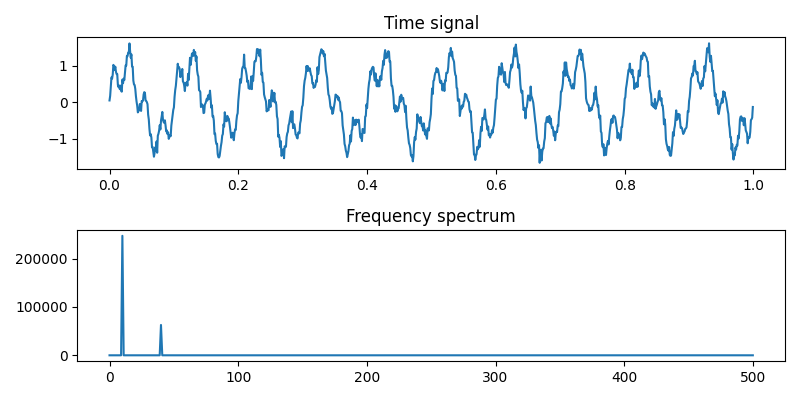

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
axs[0].plot(time, sinewave_noise)
axs[0].set_title('Time signal')
axs[1].plot(freq, fft)
axs[1].set_title('Frequency spectrum')
plt.tight_layout()

 ## Spectrogram

/home/rglitza/ai-internal_datenauswertung-praktikum_sw/env/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1000
  return f(*args, **kwargs)


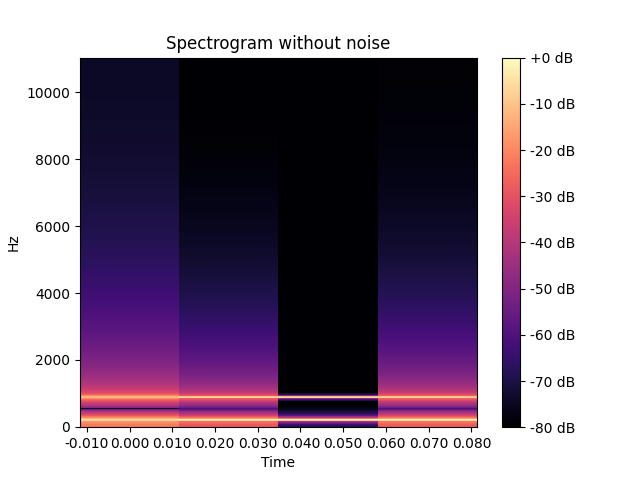

In [10]:
D = librosa.stft(sinewave, hop_length=256, n_fft=1024)  # High resolution STFT
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram without noise')
fig.colorbar(img, ax=ax, format="%+2.f dB")

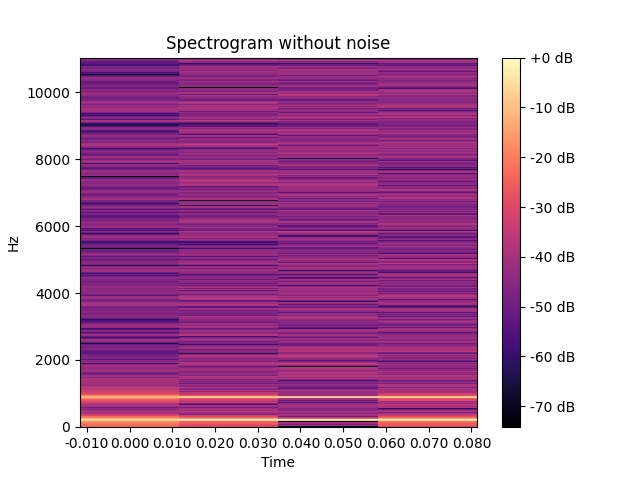

In [11]:
D = librosa.stft(sinewave_noise, hop_length=256, n_fft=1024)  # High resolution STFT
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram without noise')
fig.colorbar(img, ax=ax, format="%+2.f dB")

 ### Compose multiple sine waves

In [12]:
fs = 1e3
length = 10 # in seconds
time = np.arange(0, length, 1 / fs)

# First sine wave
theta = 0
frequency = 10
amplitude = 1
sinewaves = amplitude * np.sin(2 * np.pi * frequency * time + theta)

frequency = 2*frequency
new_wave = amplitude * np.sin(2 * np.pi * frequency * time + theta)
sinewaves = np.concatenate((sinewaves, new_wave), axis=0)

frequency = 2*frequency
new_wave = amplitude * np.sin(2 * np.pi * frequency * time + theta)
sinewaves = np.concatenate((sinewaves, new_wave), axis=0)

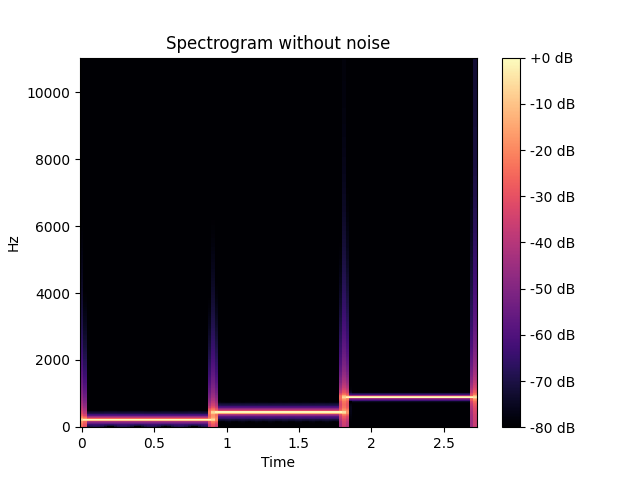

In [13]:
D = librosa.stft(sinewaves, hop_length=256, n_fft=1024)  # High resolution STFT
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram without noise')
fig.colorbar(img, ax=ax, format="%+2.f dB")

 ## Cepstrum

Text(0.5, 1.0, 'Cepstrum')

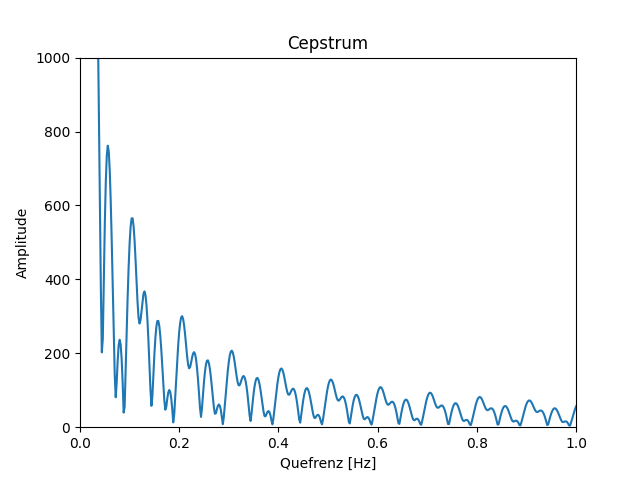

In [14]:
xlim=(0,1)
ylim=(0,1e3)
signal = sinewaves

signal = signal - np.mean(signal)

fig, ax = plt.subplots()
quefrency, ceps = DSP.complex_cepstrum(signal, fs=fs)
ax.plot(quefrency, np.abs(ceps))
ax.set_xlabel('Quefrenz [Hz]')
ax.set_ylabel(r'Amplitude')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title(f"Cepstrum")

 ## Example Analysis
 ### RMS
 $$x_{\mathrm{RMS}} = \sqrt{\frac{1}{n} \sum_{i=1}^n{x_i^2}}$$

In [15]:
rms_clean = DSP.rms(sinewave)
rms_noise = DSP.rms(noise)
rms_combined = DSP.rms(sinewave_noise)

logger.info("RMS clean: {:.2f}".format(rms_clean))
logger.info("RMS noise: {:.2f}".format(rms_noise))
logger.info("RMS combined: {:.2f}".format(rms_combined))

INFO:__main__:RMS clean: 0.79
INFO:__main__:RMS noise: 0.10
INFO:__main__:RMS combined: 0.79
INFO:__main__:RMS noise: 0.10
INFO:__main__:RMS combined: 0.79


 ## Trend Analysis

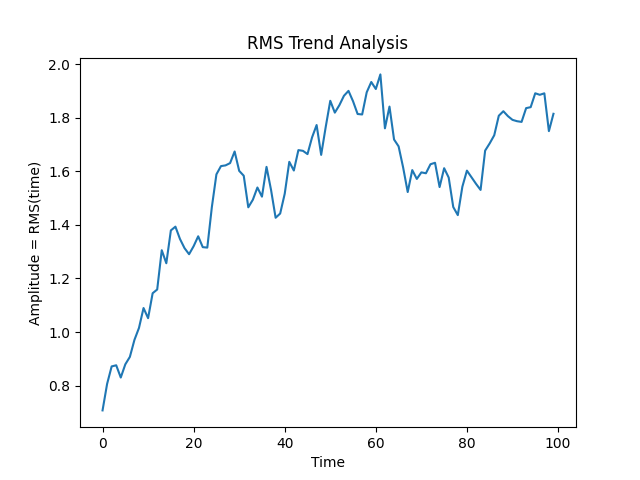

In [16]:
rms = []

theta = 0
frequency = 10
amplitude = 1

for i in range (0, 100):
    sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)
    rms.append(DSP.rms(sinewave))
    amplitude += 0.1 * np.random.randn()

plt.figure()
plt.plot(rms)
plt.title('RMS Trend Analysis')
plt.xlabel('Time')
plt.ylabel('Amplitude = RMS(time)')
plt.show()

 ## Audio Data

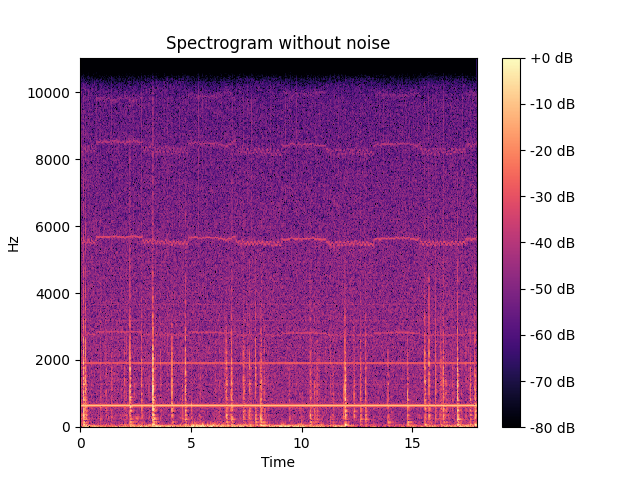

In [17]:
audio_path = os.path.abspath('../data/2022-10-23T17_22_44.027Z_rain.wav')
# y, sr = librosa.load(librosa.ex('trumpet'))
y, fs = librosa.load(audio_path)

D = librosa.stft(y, hop_length=256, n_fft=1024)  # High resolution STFT
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram without noise')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [18]:
ipd.Audio(y, rate=fs)

In [19]:
rms_df = pd.DataFrame(columns=['RMS', 'Frequency', 'Amplitude'])

# rms_df['RMS'] = rms
rms_df['Frequency'] = None
rms_df['Time'] = list(range(0, len(y)))
rms_df['Amplitude'] = y

 ## Verteilungsdichtefunktion (PDF)

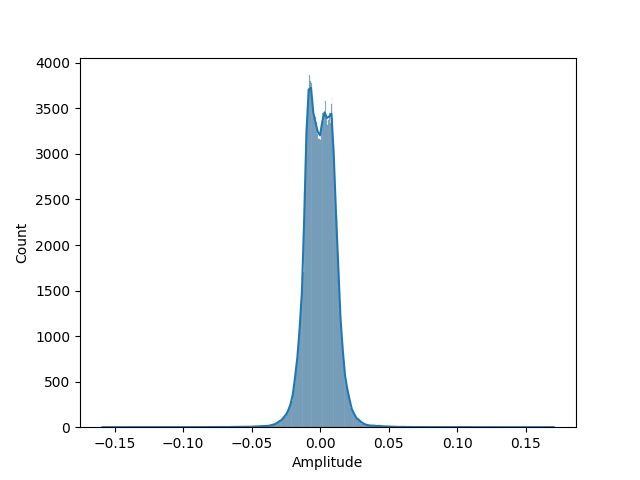

In [20]:
import seaborn as sns

rms_array = np.squeeze(rms_df['Amplitude'])
median_value = np.median(rms_array)

fig, ax = plt.subplots()
ax = sns.histplot(rms_df['Amplitude'], kde=True, ax=ax)

plt.show()

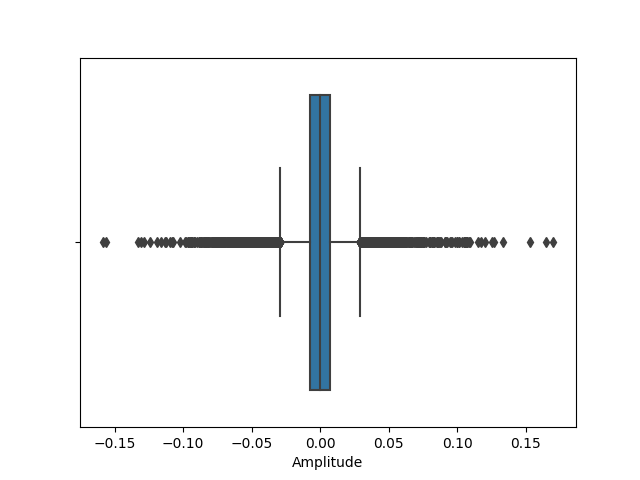

In [21]:
fig, ax = plt.subplots()
ax = sns.boxplot(x=rms_df['Amplitude'], ax=ax)
plt.show()

 ## Animations

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5qkdwu64/temp.m4v
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


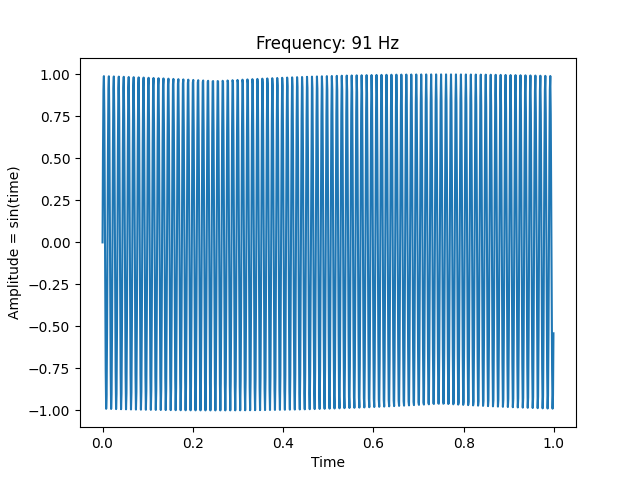

In [22]:
from IPython.display import HTML
from matplotlib.animation import PillowWriter

fs = 1e3
length = 1 # in seconds
time = np.arange(0, length, 1 / fs)

theta = 0
frequency = 1
amplitude = 1
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)

fig, ax = plt.subplots()
ax.plot(time, sinewave)
ax.set_title('Sine wave')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude = sin(time)')

def animate(i):
    global frequency

    theta = 0
    frequency += i
    amplitude = 1

    sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)

    ax.get_lines()[0].set_data(time, sinewave)

    ax.set_title(f"Frequency: {frequency} Hz")

    return ax.get_lines()[0]

length_animation = 10
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(length_animation), repeat=False )

HTML(ani.to_html5_video())

LOG_FOLDER = os.path.abspath('./logs')
os.makedirs(LOG_FOLDER, exist_ok=True)
ani.save(f"{LOG_FOLDER}/polar.gif", writer='pillow')